In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

def fetch_data(fname='seeds_dataset.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
DATA

'C:\\Users\\585160\\Documents\\Data Science\\machine-learning\\notebook\\seeds_dataset.txt'

In [4]:
# Labeing all the features

FEATURES  = [
    "alcohol",
    "malic acid",
    "ash",
    "alcalinity of ash",
    "magnesium",
    "total phenols",
    "flavanoids",
    "nonflavanoid phenols",
    "proanthocyanins",
    "color intensity",
    "hue",
    "OD280/OD315 of diluted wines",
    "proline",
]

LABEL_MAP = {
    1: "Cultivar1",
    2: "Cultivar2",
    3: "Cultivar3",
}

# Putting the data into a dataframe
df = pd.read_csv(DATA, header=None, names=FEATURES)

# Converting class labels into text
for k,v in LABEL_MAP.items():
    df.ix[df.alcohol == k, 'alcohol'] = v

# Describing the dataset
print(df.describe())

          alcohol  malic acid         ash  alcalinity of ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total phenols  flavanoids  nonflavanoid phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

In [5]:
# Determining the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determining the frequency of each class
print(df.groupby('alcohol')['alcohol'].count())

178 instances with 13 features

alcohol
11.03    1
11.41    1
11.45    1
11.46    1
11.56    1
11.61    1
11.62    1
11.64    1
11.65    1
11.66    1
11.76    1
11.79    1
11.81    1
11.82    2
11.84    2
11.87    1
11.96    1
12.00    3
12.04    1
12.07    1
12.08    5
12.16    1
12.17    1
12.20    1
12.21    1
12.22    1
12.25    3
12.29    4
12.33    2
12.34    1
        ..
13.75    1
13.76    1
13.77    1
13.78    1
13.82    1
13.83    2
13.84    1
13.86    2
13.87    1
13.88    2
13.90    1
13.94    1
14.02    1
14.06    2
14.10    2
14.12    1
14.13    1
14.16    1
14.19    1
14.20    1
14.21    1
14.22    2
14.23    1
14.30    1
14.34    1
14.37    1
14.38    2
14.39    1
14.75    1
14.83    1
Name: alcohol, dtype: int64


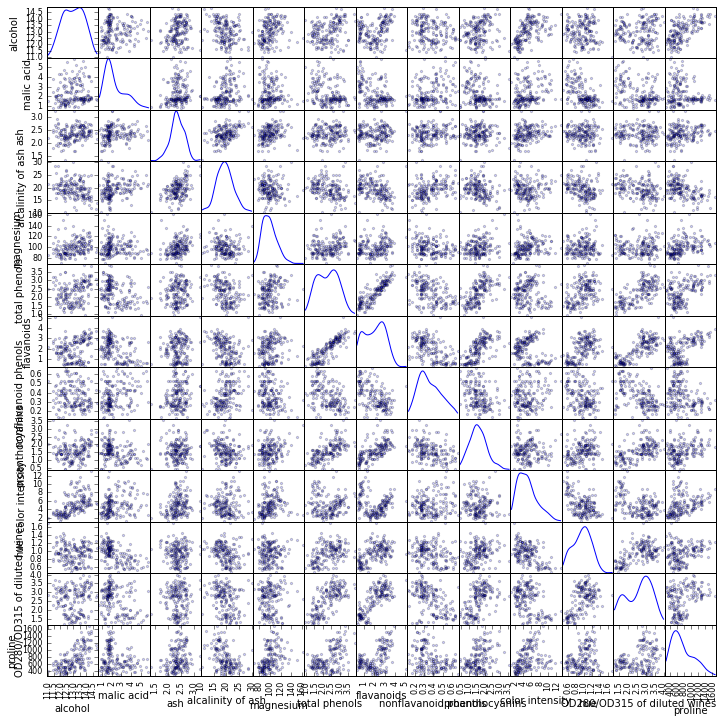

In [14]:
# Creating a scatter matrix of the dataframe features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

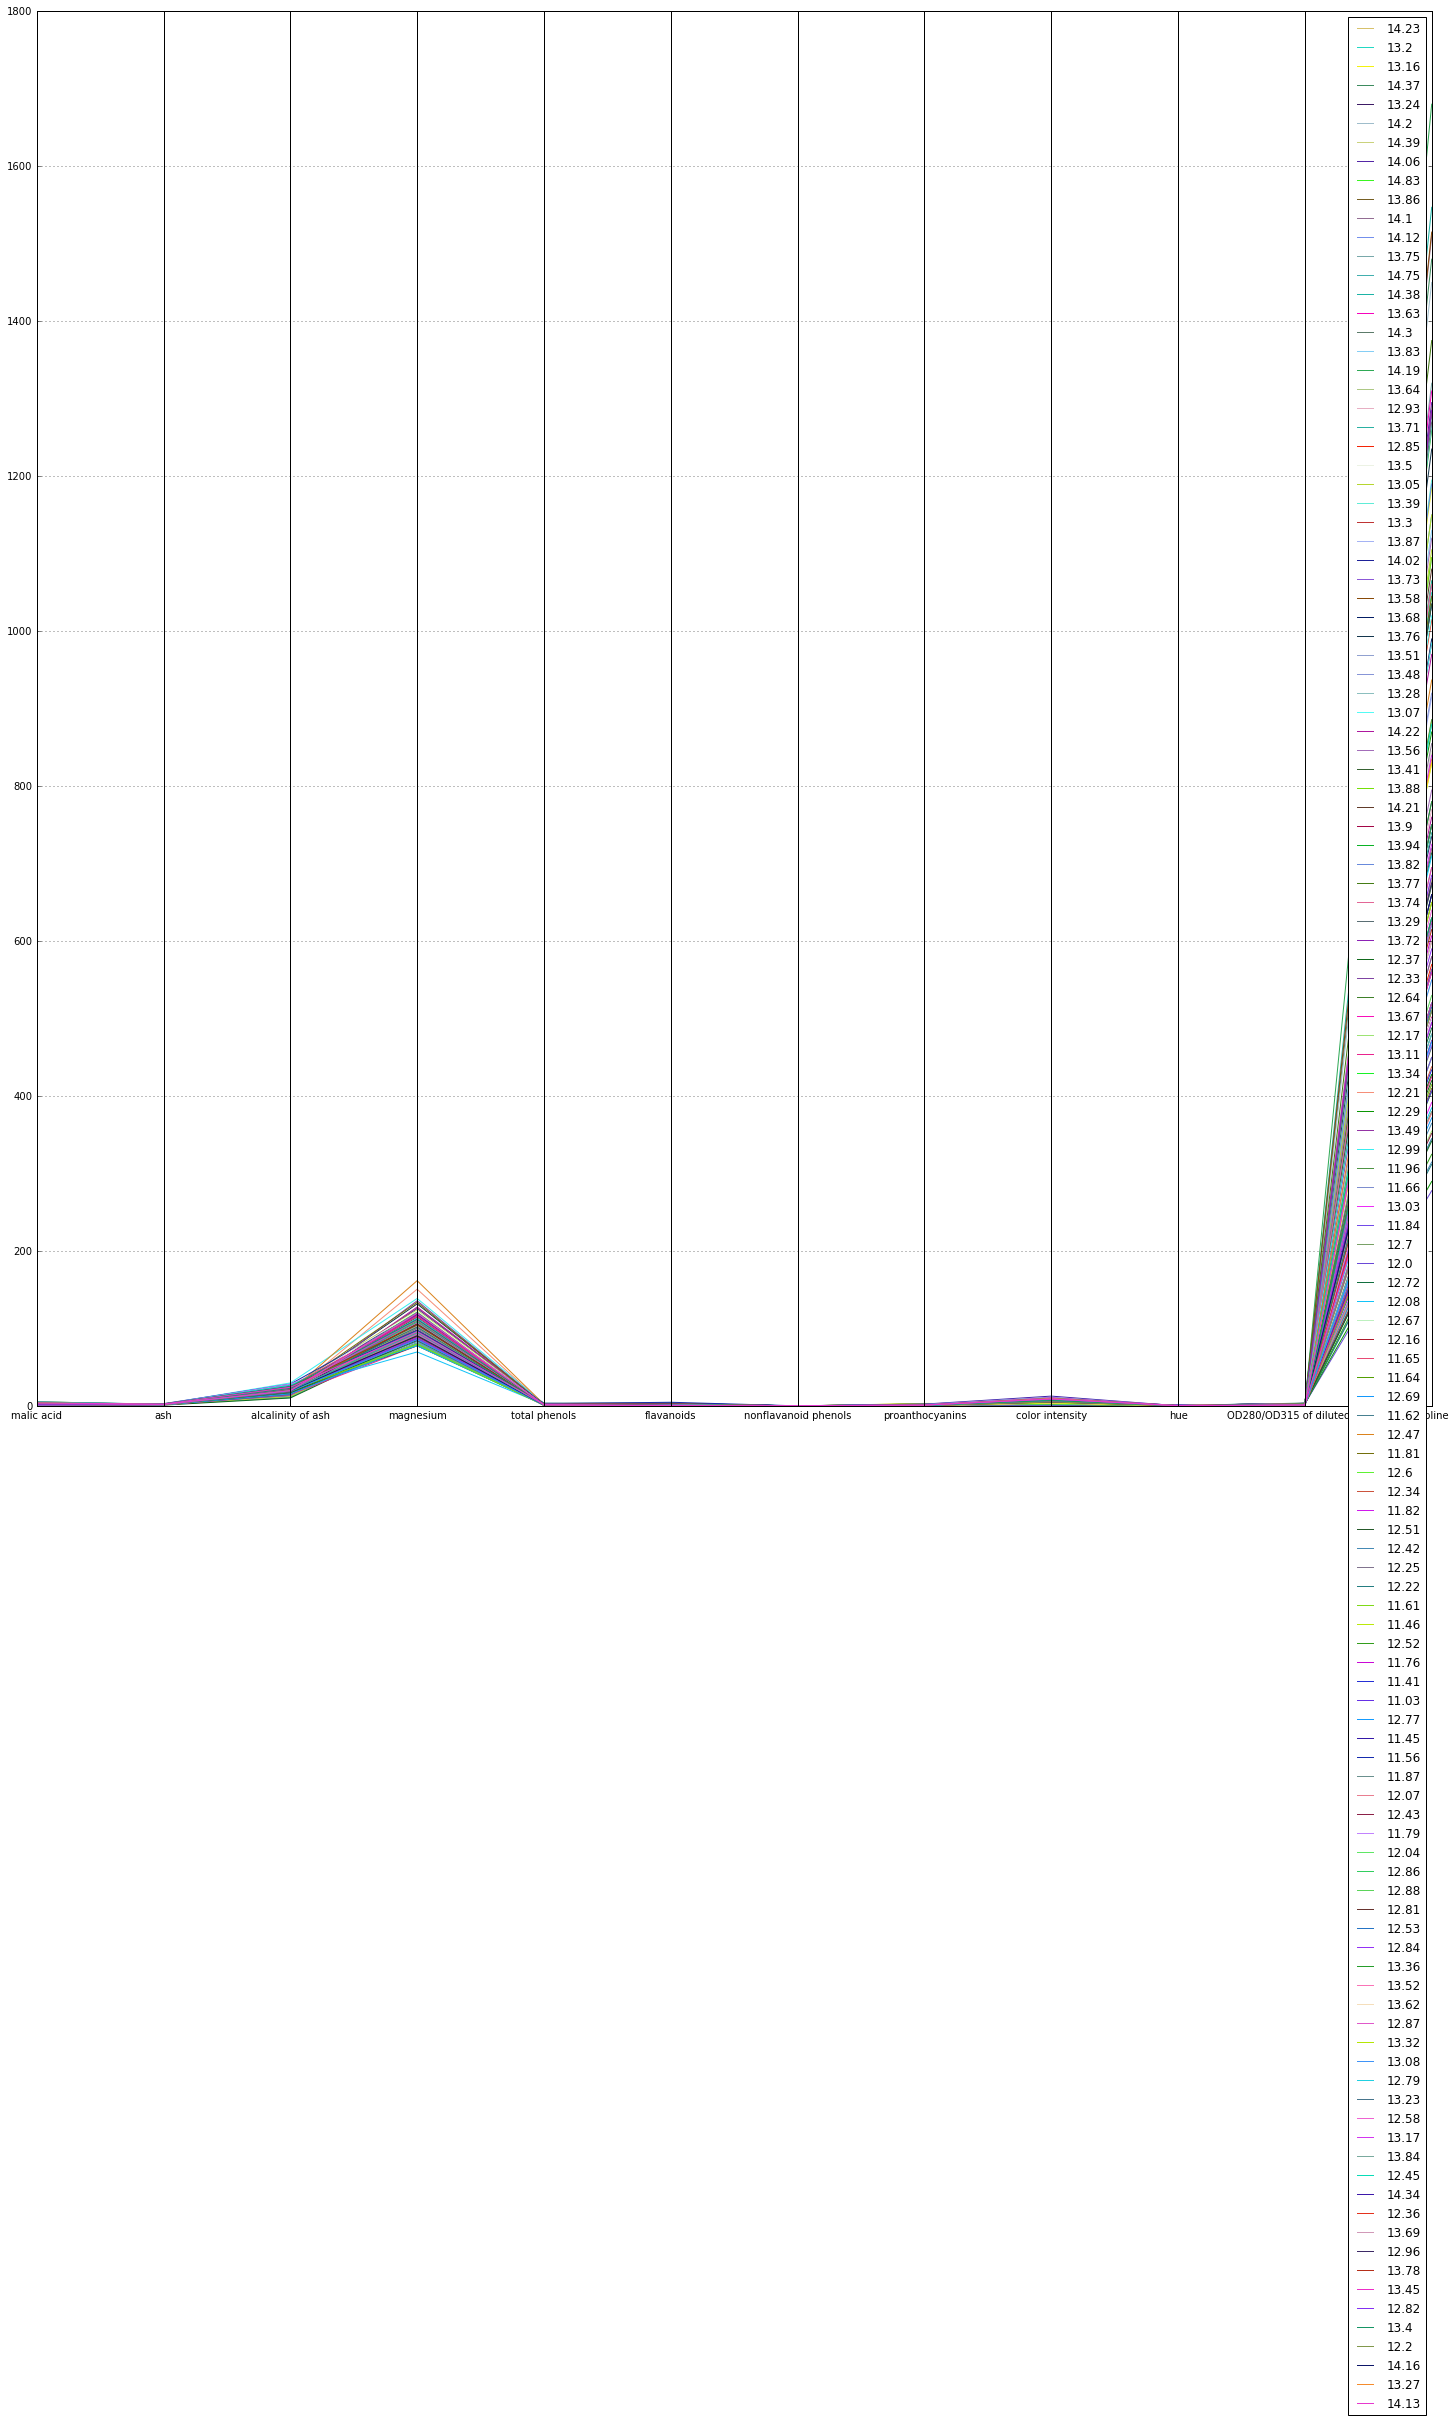

In [15]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(25,25))
parallel_coordinates(df, 'alcohol')
plt.show()

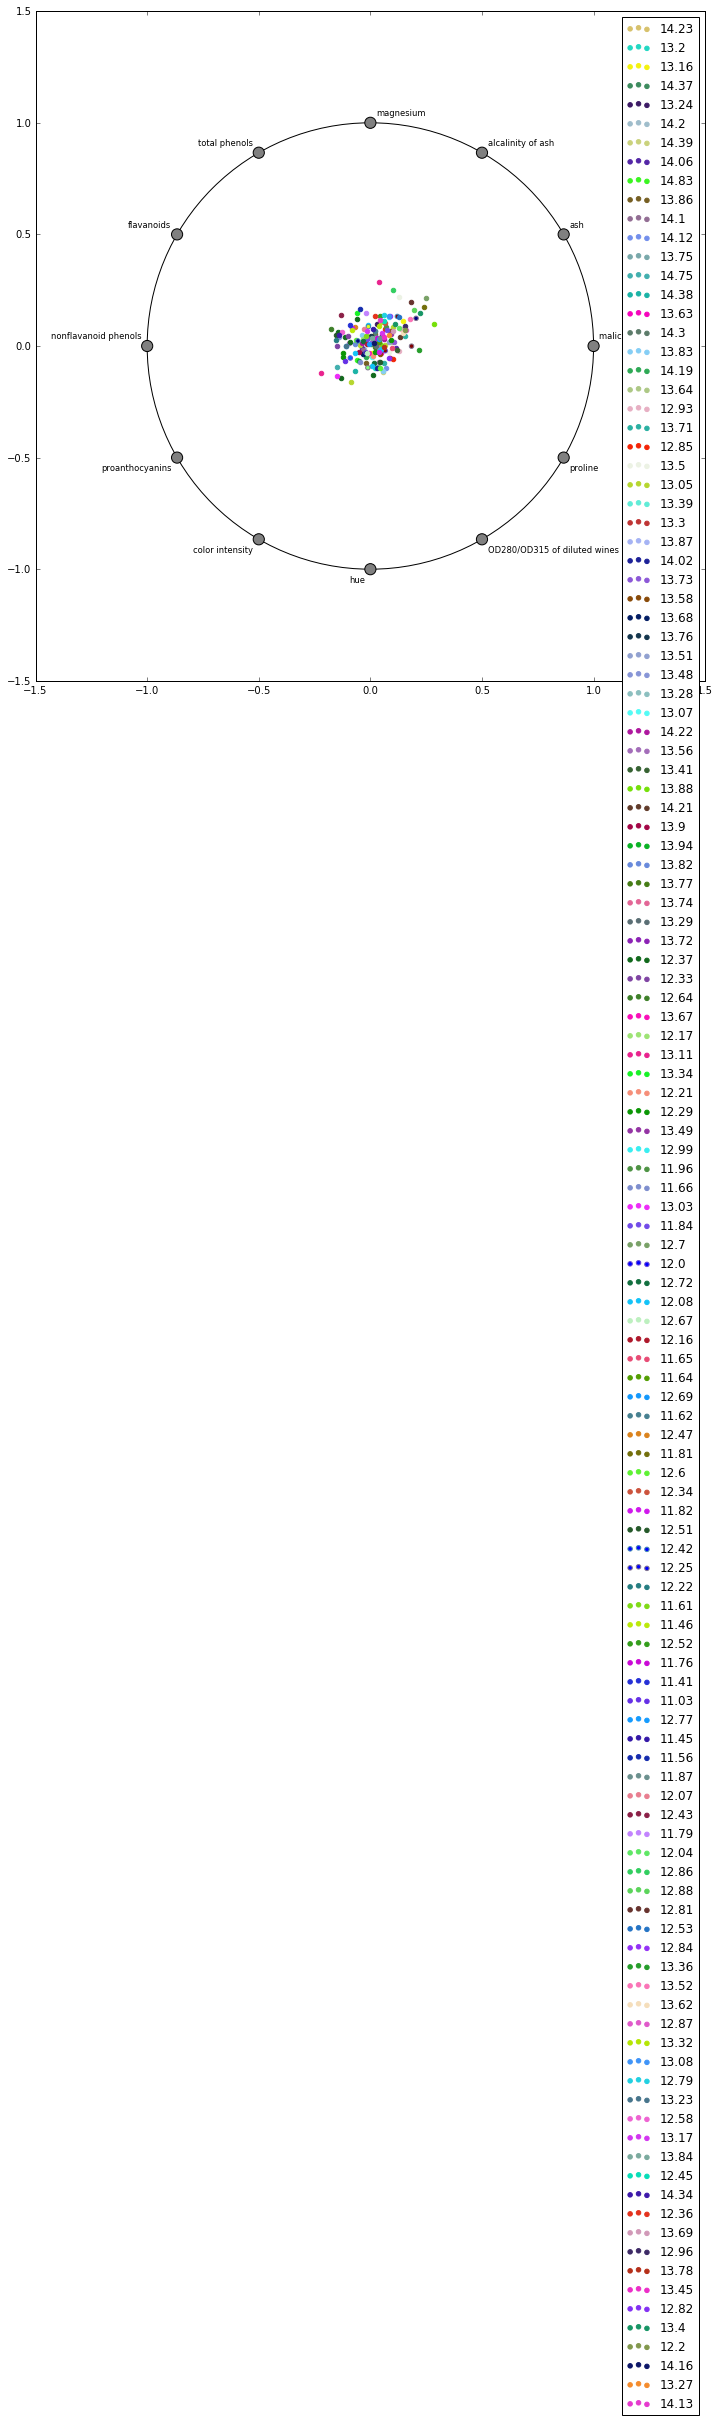

In [16]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(12,12))
radviz(df, 'alcohol')
plt.show()

In [17]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..", "data", "wine"))

# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print("- {}".format(name))

- dataset.csv
- meta.json
- README.md
- wine.txt


In [20]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the wine dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'wine.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'], delimiter=',')

    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(178, 13)
(178,)


In [22]:
# Importing the algorithms from sklearn

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [23]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [25]:
# Perform SVC Classification
fit_and_evaluate(dataset, SVC, "Wine SVM Classifier")

C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', aver

Build and Validation of Wine SVM Classifier took 0.585 seconds
Validation scores are as follows:

accuracy     0.016667
f1           0.009259
precision    0.007778
recall       0.016667
dtype: float64

Fitted model written to:
C:\Users\585160\Documents\Data Science\machine-learning\notebook\wine-svm-classifier.pickle


In [26]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Wine kNN Classifier", n_neighbors=12)

Build and Validation of Wine kNN Classifier took 0.094 seconds
Validation scores are as follows:

accuracy     0.0
f1           0.0
precision    0.0
recall       0.0
dtype: float64

Fitted model written to:
C:\Users\585160\Documents\Data Science\machine-learning\notebook\wine-knn-classifier.pickle


C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', aver

In [27]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Wine Forest Classifier")

C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', aver

Build and Validation of Wine Forest Classifier took 0.470 seconds
Validation scores are as follows:

accuracy     0.011111
f1           0.012963
precision    0.016667
recall       0.011111
dtype: float64

Fitted model written to:
C:\Users\585160\Documents\Data Science\machine-learning\notebook\wine-forest-classifier.pickle


In [28]:
# Lesson learned - none of these are good to use. Let's try Naive Bayes.

from sklearn.naive_bayes import GaussianNB

In [29]:
# Perform Naive Bayes

fit_and_evaluate(dataset, GaussianNB, "Wine Bayes Classifier" )

C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', aver

Build and Validation of Wine Bayes Classifier took 0.230 seconds
Validation scores are as follows:

accuracy     0.011111
f1           0.011111
precision    0.011111
recall       0.011111
dtype: float64

Fitted model written to:
C:\Users\585160\Documents\Data Science\machine-learning\notebook\wine-bayes-classifier.pickle


In [30]:
# Let's try LDA

from sklearn.lda import LDA

C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [31]:
fit_and_evaluate(dataset, LDA, "Wine LDA Classifier")

Build and Validation of Wine LDA Classifier took 0.195 seconds
Validation scores are as follows:

accuracy     0.005556
f1           0.005556
precision    0.005556
recall       0.005556
dtype: float64

Fitted model written to:
C:\Users\585160\Documents\Data Science\machine-learning\notebook\wine-lda-classifier.pickle


C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\si

In [32]:
# This is even worse. Let's try Logistic Regression

from sklearn.linear_model import LogisticRegression

In [34]:
# Performing Logistic Regression

fit_and_evaluate(dataset, LogisticRegression, "Wine Logistic Regression Classifier")

C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\585160\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', aver

Build and Validation of Wine Logistic Regression Classifier took 0.808 seconds
Validation scores are as follows:

accuracy     0.011111
f1           0.011111
precision    0.011111
recall       0.011111
dtype: float64

Fitted model written to:
C:\Users\585160\Documents\Data Science\machine-learning\notebook\wine-logistic-regression-classifier.pickle
